In [3]:
import glob
import os.path as osp
import random
from itertools import product
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import json
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import pytorch_lightning as pl
from test_tube import Experiment

In [6]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
from utils.match import match

In [9]:
class AnnoXml2List():
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, width, height):
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            bndbox = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in pts:
                cur_pixel = int(bbox.find(pt).text) - 1
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                    
                bndbox.append(cur_pixel)
        
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            ret.append(bndbox)
    
        return np.array(ret)

In [10]:
from utils.data_augumentation import (
    Compose, ConvertFromInts, ToAbsoluteCoords,
    PhotometricDistort, Expand, RandomSampleCrop, RandomMirror,
    ToPercentCoords, Resize, SubtractMeans
)

class DataTransform():
    
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            'val': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }
        
    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)

In [11]:
class VOCDataset(data.Dataset):
    
    def __init__(self, phase, transform, transform_anno):
        img_list, anno_list = self._make_datapath_list(phase=phase)
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt
    
    def _make_datapath_list(self, phase):
        rootpath = '../original/2_objectdetection/data/VOCdevkit/VOC2012/'
        imgpath_template = osp.join(rootpath, 'JPEGImages', '{}.jpg')
        annopath_template = osp.join(rootpath, 'Annotations', '{}.xml')
        
        id_names = osp.join(rootpath, 'ImageSets/Main/{}.txt'.format(phase))
        img_list = []
        anno_list = []
        with open(id_names) as f:
            for line in f:
                file_id = line.strip()
                img_list.append(imgpath_template.format(file_id))
                anno_list.append(annopath_template.format(file_id))
        return img_list, anno_list
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape
        
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4]
        )
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return img, gt, height, width

In [12]:
color_mean = (104, 117, 123)
input_size = 300
voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]

train_dataset = VOCDataset(
    phase='train',
    transform=DataTransform(
        input_size, color_mean
    ),
    transform_anno=AnnoXml2List(voc_classes)
)
val_dataset = VOCDataset(
    phase='val',
    transform=DataTransform(
        input_size, color_mean
    ),
    transform_anno=AnnoXml2List(voc_classes)
)
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [13]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    
    imgs = torch.stack(imgs, dim=0)
    return imgs, targets
bi = iter(data.DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=od_collate_fn))
images, targets = next(bi)
print(images.size())
print(len(targets))
print(targets[1].size())

torch.Size([256, 3, 300, 300])
256
torch.Size([2, 5])


In [14]:
def make_vgg():
    layers = []
    in_channels = 3
    
    cfg = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'MC',
        512, 512, 512, 'M', 512, 512, 512
    ]
    
    for v in cfg:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        elif v == 'MC':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True))
        else:
            layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v
        
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [
        pool5,
        conv6,
        nn.ReLU(inplace=True),
        conv7,
        nn.ReLU(inplace=True),  
    ]
    return nn.ModuleList(layers)

vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [15]:
def make_extras():
    layers = []
    in_channels = 1024
    
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]
    
    layers.append(nn.Conv2d(in_channels, cfg[0], kernel_size=(1)))
    layers.append(nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1))
    layers.append(nn.Conv2d(cfg[1], cfg[2], kernel_size=(1)))
    layers.append(nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1))
    layers.append(nn.Conv2d(cfg[3], cfg[4], kernel_size=(1)))
    layers.append(nn.Conv2d(cfg[4], cfg[5], kernel_size=(3)))
    layers.append(nn.Conv2d(cfg[5], cfg[6], kernel_size=(1)))
    layers.append(nn.Conv2d(cfg[6], cfg[7], kernel_size=(3)))
    
    return nn.ModuleList(layers)

extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [16]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    conf_layers = []
    
    loc_layers.append(nn.Conv2d(512, bbox_aspect_num[0] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(512, bbox_aspect_num[0] * num_classes, kernel_size=3, padding=1))
    
    loc_layers.append(nn.Conv2d(1024, bbox_aspect_num[1] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, kernel_size=3, padding=1))
    
    loc_layers.append(nn.Conv2d(512, bbox_aspect_num[2] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(512, bbox_aspect_num[2] * num_classes, kernel_size=3, padding=1))
    
    loc_layers.append(nn.Conv2d(256, bbox_aspect_num[3] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(256, bbox_aspect_num[3] * num_classes, kernel_size=3, padding=1))
    
    loc_layers.append(nn.Conv2d(256, bbox_aspect_num[4] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(256, bbox_aspect_num[4] * num_classes, kernel_size=3, padding=1))
    
    loc_layers.append(nn.Conv2d(256, bbox_aspect_num[5] * 4, kernel_size=3, padding=1))
    conf_layers.append(nn.Conv2d(256, bbox_aspect_num[5] * num_classes, kernel_size=3, padding=1))
    
    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [17]:
class L2Norm(nn.Module):
    
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters()
        self.eps = 1e-10
        
    def reset_parameters(self):
        nn.init.constant_(self.weight, self.scale)
        
    def forward(self, x):
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps
        x = torch.div(x, norm)
        
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x
        return out

In [18]:
class DBox():
    
    def __init__(self, cfg):
        super(DBox, self).__init__()
        self.image_size = cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg['feature_maps'])
        self.steps = cfg['steps']
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.aspect_ratios = cfg['aspect_ratios']
        
    def make_dbox_list(self):
        mean = []
        
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]
                
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                
                s_k = self.min_sizes[k] / self.image_size
                mean.append([cx, cy, s_k, s_k])
                
                s_k_prime = np.sqrt(s_k * (self.max_sizes[k] / self.image_size))
                mean.append([cx, cy, s_k_prime, s_k_prime])
                
                for ar in self.aspect_ratios[k]:
                    mean.append([cx, cy, s_k * np.sqrt(ar), s_k / np.sqrt(ar)])
                    mean.append([cx, cy, s_k / np.sqrt(ar), s_k * np.sqrt(ar)])
                    
        output = torch.Tensor(mean).view(-1, 4)
        output.clamp_(max=1, min=0)
        return output

ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [43]:
class Detect(torch.autograd.Function):
    
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh
        
    def _decode(self, loc, dbox_list):
        boxes = torch.cat((
            dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
            dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)
        ), dim=1)
        
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2]
        return boxes
    
    def _nm_suppression(self, boxes, scores):
        count = 0
        keep = scores.new(scores.size(0)).zero_().long()
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        area = torch.mul(x2 - x1, y2 - y1)
        
        tmp_x1 = boxes.new()
        tmp_y1 = boxes.new()
        tmp_x2 = boxes.new()
        tmp_y2 = boxes.new()
        tmp_w = boxes.new()
        tmp_h = boxes.new()
        
        v, idx = scores.sort(0)
        idx = idx[-self.top_k:]
        
        while idx.numel() > 0:
            i = idx[-1]
            keep[count] = i
            count += 1
            
            if idx.size(0) == 1:
                break
            
            idx = idx[:-1]
            
            torch.index_select(x1, 0, idx, out=tmp_x1)
            torch.index_select(y1, 0, idx, out=tmp_y1)
            torch.index_select(x2, 0, idx, out=tmp_x2)
            torch.index_select(y2, 0, idx, out=tmp_y2)
            
            tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
            tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
            tmp_x2 = torch.clamp(tmp_x2, min=x2[i])
            tmp_y2 = torch.clamp(tmp_y2, min=y2[i])
            
            tmp_w.resize_as_(tmp_x2)
            tmp_h.resize_as_(tmp_y2)
            
            tmp_w = tmp_x2 - tmp_x1
            tmp_h = tmp_y2 - tmp_y1
            
            tmp_w = torch.clamp(tmp_w, min=0.0)
            tmp_h = torch.clamp(tmp_h, min=0.0)
            
            inter = tmp_w * tmp_h
            
            rem_areas = torch.index_select(area, 0, idx)
            union = (rem_areas - inter) + area[i]
            iou = inter / union
            
            idx = idx[iou.le(self.nms_thresh)]
            
        return keep, count
    
    def forward(self, loc_data, conf_data, dbox_list):
        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)
        
        conf_data = self.softmax(conf_data)
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)
        conf_preds = conf_data.transpose(2, 1)
        
        for i in range(num_batch):
            decoded_boxes = self._decode(loc_data[i], dbox_list)
            conf_scores = conf_preds[i].clone()
            
            for cl in range(1, num_classes):
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                scores = conf_scores[cl][c_mask]
                
                if scores.nelement() == 0:
                    continue
                    
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                boxes = decoded_boxes[l_mask].view(-1, 4)
                ids, count = self._nm_suppression(
                    boxes, scores)
                output[i, cl, :count] = torch.cat((
                    scores[ids[:count]].unsqueeze(1),
                    boxes[ids[:count]]), 1)
        
        return output
            

class SSD(nn.Module):
    
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()
        
        self.phase = phase
        self.num_classes = cfg['num_classes']
        
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg['num_classes'], cfg['bbox_aspect_num']
        )
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()
        
        if phase == 'inference':
            self.detect = Detect()
            
    def forward(self, x):
        sources = []
        loc = []
        conf = []
        
        for k in range(23):
            x = self.vgg[k](x)
        
        source1 = self.L2Norm(x)
        sources.append(source1)
        
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        
        sources.append(x)
        
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)
                
        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
        
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)
        
        output = (loc, conf, self.dbox_list)
        
        if self.phase == 'inference':
            return self.detect(output[0], output[1], output[2])
        else:
            return output

In [20]:
class MultiBoxLoss(nn.Module):
    
    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh
        self.negpos_ratio = neg_pos
        self.device = device
        
    def forward(self, predictions, targets):
        loc_data, conf_data, dbox_list = predictions
        
        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)
        
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)
        
        for idx in range(num_batch):
            truths = targets[idx][:, :-1].to(self.device)
            labels = targets[idx][:, -1].to(self.device)
            dbox = dbox_list.to(self.device)
            variance = [0.1, 0.2]
            match(
                self.jaccard_thresh, truths, dbox,
                variance, labels, loc_t, conf_t_label, idx)
        
        pos_mask = conf_t_label > 0
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')
        
        batch_conf = conf_data.view(-1, num_classes)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')
        
        num_pos = pos_mask.long().sum(1, keepdim=True)
        loss_c = loss_c.view(num_batch, -1)
        loss_c[pos_mask] = 0
        
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        
        num_neg = torch.clamp(num_pos * self.negpos_ratio, max=num_dbox)
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)
        
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)
        
        conf_hnm = conf_data[(pos_idx_mask + neg_idx_mask).gt(0)].view(-1, num_classes)
        conf_t_label_hnm = conf_t_label[(pos_mask + neg_mask).gt(0)]
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')
        
        n = num_pos.sum()
        loss_l /= n
        loss_c /= n
        
        return loss_l, loss_c

In [76]:
class VOCModel(pl.LightningModule):

    def __init__(self, train_ds, val_ds, collate_fn, batch_size, ssd_cfg):
        super(VOCModel, self).__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.collate_fn = collate_fn
        self.batch_size = batch_size
        self.net = SSD(phase='train', cfg=ssd_cfg)
        # self.net = utils.SSD(phase='train', cfg=ssd_cfg)
        vgg_weights = torch.load('../original/2_objectdetection/weights/vgg16_reducedfc.pth')
        self.net.vgg.load_state_dict(vgg_weights)
        self.net.extras.apply(self._weights_init)
        self.net.loc.apply(self._weights_init)
        self.net.conf.apply(self._weights_init)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss_l, loss_c = self.criterion(y_hat, y)
        return {'loss': loss_l + loss_c}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss_l, loss_c = self.criterion(y_hat, y)
        return {
            'val_loss': loss_l + loss_c,
        }

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {
            'avg_val_loss': avg_loss,
        }

    def configure_optimizers(self):
        return optim.SGD(self.net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

    @pl.data_loader
    def tng_dataloader(self):
        return data.DataLoader(self.train_ds, collate_fn=self.collate_fn, shuffle=True, batch_size=self.batch_size)

    @pl.data_loader
    def val_dataloader(self):
        return data.DataLoader(self.val_ds, collate_fn=self.collate_fn, shuffle=False, batch_size=self.batch_size)

In [82]:
model = VOCModel(train_dataset, val_dataset, od_collate_fn, 32, ssd_cfg)
exp = Experiment(save_dir='./logs')
trainer = pl.Trainer(experiment=exp, max_nb_epochs=50, add_log_row_interval=1, gradient_clip=0.2, gpus=[0, 1])
trainer.fit(model)

  0%|          | 0/5 [00:00<?, ?it/s]

VISIBLE GPUS: '0,1'
gpu available: True, used: True
          Name          Type    Params
0          net           SSD  26285486
1      net.vgg    ModuleList  20483904
2    net.vgg.0        Conv2d      1792
3    net.vgg.1          ReLU         0
4    net.vgg.2        Conv2d     36928
..         ...           ...       ...
57  net.conf.2        Conv2d    580734
58  net.conf.3        Conv2d    290430
59  net.conf.4        Conv2d    193620
60  net.conf.5        Conv2d    193620
61   criterion  MultiBoxLoss         0

[62 rows x 3 columns]


  7%|▋         | 26/361 [00:24<05:34,  1.00it/s, batch_nb=24, epoch=0, gpu=0, loss=27.078, v_nb=0]

KeyboardInterrupt: 

In [83]:
torch.save(model.net.state_dict(), 'weights/ssd300_50.pth')

In [84]:
net = SSD(phase='inference', cfg=ssd_cfg)
net_weights = torch.load('weights/ssd300_50.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

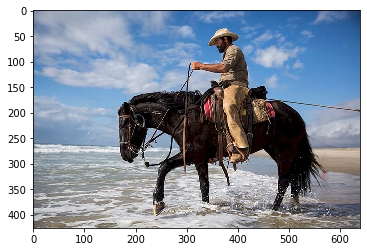

torch.Size([1, 21, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.5557,  0.5175,  0.8115,  0.6672,  0.8848],
          [ 0.4063,  0.7286, -0.0021,  0.7988,  0.1360],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.6860,  0.4789,  0.0056,  0.6367,  0.2076],
          [ 0.6506,  0.6033,  0.6116,  0.7099,  0.6838],
          [ 0.6266,  0.1700,  0.3952,  0.3814,  0.4812],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [

In [85]:
image_file_path = '../original/2_objectdetection/data/cowboy-757575_640.jpg'
img = cv2.imread(image_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)
phase = 'val'
img_transformed, boxes, labels = transform(
    img, phase, '', '')
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

x = img.unsqueeze(0)
detections = net(x)
print(detections.shape)
print(detections)

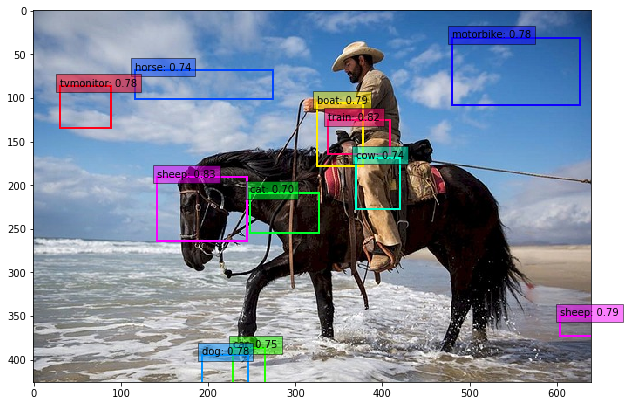

In [90]:
from utils.ssd_predict_show import SSDPredictShow

ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.7)